In [1]:
import classes
import caffemodel2pytorch as caffe

# modified visualpriors library
from transforms import VisualPriorRepresentation, VisualPriorPredictedLabel
from taskonomy_network import TaskonomyEncoder, TaskonomyDecoder

import os
import collections
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torchsummary

from PIL import Image
from scipy.stats import pearsonr

import torch.utils.model_zoo # required to load nets
import torchvision.transforms.functional as TF
from torch import nn
import torchvision.models
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

#%load_ext autoreload
#%autoreload 2

In [ ]:
"""
Notebook for using ImageDataset and IntegrationCalculator class

"""

# Load Taskonomy Network

In [2]:
task = 'autoencoding'

VisualPriorRepresentation._load_unloaded_nets([task]) # preload nets
net = VisualPriorRepresentation.feature_task_to_net[task] # loads encoder only for representations
torchsummary.summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# Create tweaked net for retrieving activations

In [ ]:
train_nodes, eval_nodes = get_graph_node_names(net)
print(len(eval_nodes))
eval_nodes


In [ ]:
return_nodes = { k:k for k in ['conv1']+[node for node in eval_nodes if "conv3" in node]}

In [ ]:
net_tweaked = create_feature_extractor(net, return_nodes=return_nodes)
net_tweaked

# Load Image, convert to tensor, create image parts

In [30]:
def checkerboard(scale, output_size=640):
    board = np.indices((scale,scale)).sum(axis=0) % 2
    board = board.repeat(output_size/scale,axis=0).repeat(output_size/scale, axis=1)
    board = board[np.newaxis,:,:].repeat(3,axis=0)
    return board.astype(dtype = np.bool_)

In [ ]:
img = Image.open('./data/stimuli_places1/Places365_val_00036011.jpg')
img = img.resize((640,640))

In [26]:
img = torchvision.io.read_image('./data/stimuli_places1/Places365_val_00001153.jpg')
img.shape

torch.Size([3, 683, 512])

In [27]:
img_resizer = torchvision.transforms.Resize((224,224))

In [28]:
img = img_resizer(img)
img.shape

torch.Size([3, 224, 224])

In [31]:
pattern = checkerboard(2, output_size=224)
pattern.shape

(3, 224, 224)

In [36]:
img[pattern] = 127
img.shape

torch.Size([3, 224, 224])

In [34]:
from helpers import plot

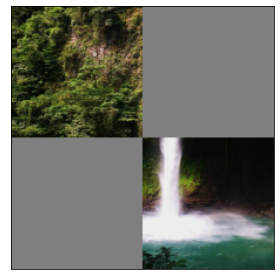

In [37]:
plot([img])

In [ ]:
# old
img = np.array(img)

img1, img2 = np.where(checkerboard(4), img, 255), np.where(~checkerboard(4), img, 255)

img, img1, img2 = Image.fromarray(img), Image.fromarray(img1), Image.fromarray(img2)
img, img1, img2 = TF.to_tensor(TF.resize(img, 256)) * 2 - 1, TF.to_tensor(TF.resize(img1, 256)) * 2 - 1, TF.to_tensor(TF.resize(img2, 256)) * 2 - 1
img, img1, img2 = img.unsqueeze_(0), img1.unsqueeze_(0), img2.unsqueeze_(0)
img.shape, img1.shape, img2.shape

# Get activations for image and image parts

In [ ]:
img_act = net_tweaked(img)
img1_act = net_tweaked(img1)
img2_act = net_tweaked(img2)

# Calculate average activation for image parts

In [ ]:
img12avg_act = { k:None for k in img_act.keys()}
img12avg_act.keys()

In [ ]:
for layer in img_act.keys():
    img12avg_act[layer] = torch.stack((img1_act[layer], img2_act[layer]), dim=0).mean(dim=0)

In [ ]:
print("Sanity check on average partial and full activations")
for layer in img_act.keys():
    print(img_act[layer].shape == img12avg_act[layer].shape)

# Integration coeficient

In [ ]:
integration = { k:None for k in img_act.keys()}

for (layer_name, a1, a2) in zip(integration.keys(), img_act.values(), img12avg_act.values()):
    integration[layer_name] = pearsonr(a1.flatten(), a2.flatten())[0]

In [ ]:
integration

In [ ]:
plt.plot(list(integration.values()))

# Read beauty ratings


In [ ]:
pd.read_csv('~/Documents/Thesis/Taskonomy Integration/behavior/ratings_study1.csv', header=None).mean(axis=1)

In [ ]:
img_dir = '/home/max/Documents/Thesis/Taskonomy Integration/data/stimuli_places1'
l = list(f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f)) and f.endswith('.jpg'))
l.sort()
l

In [ ]:
pl_dataset= classes.ImageDataset('/home/max/Documents/Thesis/Taskonomy Integration/data/stimuli_places1')
pl_it = iter(pl_dataset)

# Correlate integration with beauty

In [ ]:
inc = classes.IntegrationCalculator(net, return_nodes)

In [ ]:
pl_dataset= classes.ImageDataset('./data/stimuli_places1', beauty_ratings_path='./behavior/ratings_study1.csv')

In [ ]:
l = []
for idx, img in enumerate(iter(pl_dataset)):
    l.append(inc.integration_coeff(img))
    if idx == 40:
        break

res = pd.DataFrame(l, columns=inc.evalutation_layers)

In [ ]:
pl_dataset.beauty_ratings

In [ ]:
res

In [ ]:
res.aggregate(lambda x: pearsonr(x, ratings)[0], axis= 0).plot()

# Linear Modelling

In [ ]:
"""
   X: Integration measures, DataFrame (num_images x num_layers)
   y: Beauty reatings, Series (num_images x 1)
"""
pl_dataset.beauty_ratings
res


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut

In [ ]:
X = StandardScaler().fit_transform(res)
y = StandardScaler().fit_transform(pd.DataFrame(pl_dataset.beauty_ratings)[0:40+1])
X.shape, y.shape

In [ ]:
loo = LeaveOneOut()
l = []
for train_idx, predict_idx in loo.split(X):
    glm = LinearRegression().fit(X[train_idx], y[train_idx])
    l.append(glm.predict(X[predict_idx]).item())

In [ ]:
predictions = pd.Series(l)
predictions

In [ ]:
pl_dataset.beauty_ratings[0:40+1]

In [ ]:
pearsonr(predictions, pl_dataset.beauty_ratings[0:40+1])

# Checking implementation with vgg16_places net

## Load vgg16_places365 weights from converted caffe model

In [2]:
# can only do inference with this, but cannot retrieve intermediate activations
vgg16_places_inference_net = caffe.Net(prototxt='deploy_vgg16_places365.prototxt', weights='vgg16_places365.caffemodel', caffe_proto='https://raw.githubusercontent.com/BVLC/caffe/master/src/caffe/proto/caffe.proto')

caffemodel2pytorch: loading model from [vgg16_places365.caffemodel] in HDF5 format failed [Unable to open file (file signature not found)], falling back to caffemodel format
caffemodel2pytorch: loaded model from [vgg16_places365.caffemodel] in caffemodel format


In [3]:
# get information about model architecture nevertheless
torchsummary.summary(vgg16_places_inference_net, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       Convolution-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
       Convolution-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
       Convolution-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
       Convolution-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
      Convolution-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
      Convolution-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [3]:
# load converted model to check for additional information
vgg16_places_statedict = torch.load('vgg16_places365.caffemodel.pt')

In [ ]:
# get parameter names (need to match those in model definition)
list(name for name, _ in vgg16_places_statedict.named_parameters())

## Inspect a vanilla vgg16 network

In [ ]:

vgg16_vanilla = torchvision.models.vgg16()
#vgg16_vanilla.features = torch.nn.Sequential(collections.OrderedDict(zip(['conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2', 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'pool5'], vgg16_vanilla.features)))
#vgg16_vanilla.classifier = torch.nn.Sequential(collections.OrderedDict(zip(['fc6', 'relu6', 'drop6', 'fc7', 'relu7', 'drop7', 'fc8'], vgg16_vanilla.classifier)))
torchsummary.summary(vgg16_vanilla, (3, 224, 224))

## Initialise vgg16_places365 architecture

In [7]:
vgg16_places = nn.Sequential(
    collections.OrderedDict(
        [
            ('conv1_1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)),
            ('ReLU1_1', nn.ReLU()),
            ('conv1_2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)),
            ('ReLU1_2',nn.ReLU()),
            ('MaxPool1', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv2_1',nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)),
            ('ReLU2_1',nn.ReLU()),
            ('conv2_2',nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)),
            ('ReLU2_2',nn.ReLU()),
            ('MaxPool2', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv3_1', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)),
            ('ReLU3_1',nn.ReLU()),
            ('conv3_2', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)),
            ('ReLU3_2',nn.ReLU()),
            ('conv3_3', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)),
            ('ReLU3_3',nn.ReLU()),
            ('MaxPool3', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv4_1', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU4_1',nn.ReLU()),
            ('conv4_2', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU4_2',nn.ReLU()),
            ('conv4_3', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU4_3',nn.ReLU()),
            ('MaxPool4', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv5_1', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU5_1',nn.ReLU()),
            ('conv5_2', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU5_2',nn.ReLU()),
            ('conv5_3', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU5_3',nn.ReLU()),
            ('MaxPool5', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('Flatten6', nn.Flatten()),
            ('fc6', nn.Linear(in_features=25088, out_features=4096)),
            ('ReLU6',nn.ReLU()),
            ('fc7', nn.Linear(in_features=4096, out_features=4096)),
            ('ReLU7',nn.ReLU()),
            ('fc8a', nn.Linear(in_features=4096, out_features=365)),
            ('Softmax8a', nn.Softmax(dim=-1))
        ]
    )
)
torchsummary.summary(vgg16_places, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [10]:
vgg16_places.load_state_dict(torch.load('vgg16_places365.caffemodel.pt'))

<All keys matched successfully>

In [6]:
vgg16_places_statedict

{'conv1_1.weight': tensor([[[[ 0.3372,  0.3692, -0.0315],
           [ 0.2289,  0.0854, -0.2699],
           [-0.1009, -0.2671, -0.3517]],
 
          [[ 0.3899,  0.4098, -0.0200],
           [ 0.2631,  0.1020, -0.2826],
           [-0.0947, -0.2817, -0.3859]],
 
          [[ 0.3468,  0.3786, -0.0225],
           [ 0.2262,  0.0798, -0.2800],
           [-0.1114, -0.2863, -0.3753]]],
 
 
         [[[ 0.1461,  0.1780,  0.1571],
           [ 0.1843,  0.2210,  0.1985],
           [ 0.1690,  0.1991,  0.1777]],
 
          [[-0.0056,  0.0109,  0.0057],
           [ 0.0046,  0.0249,  0.0183],
           [ 0.0073,  0.0209,  0.0147]],
 
          [[-0.1657, -0.1648, -0.1534],
           [-0.1818, -0.1783, -0.1677],
           [-0.1625, -0.1650, -0.1550]]],
 
 
         [[[-0.0412, -0.0339, -0.1468],
           [ 0.0900,  0.0905, -0.1098],
           [-0.0273, -0.0213, -0.1435]],
 
          [[ 0.0390,  0.0400, -0.0934],
           [ 0.1823,  0.1761, -0.0478],
           [ 0.0583,  0.0587, -0.08

#

In [11]:
vgg16_places

Sequential(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU1_2): ReLU()
  (MaxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU2_2): ReLU()
  (MaxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU3_3): ReLU()
  (MaxPool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(